In [1]:
import pandas as pd
import geopandas as gpd

import requests
import xml.etree.ElementTree as ET

url = "https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/SDAPCD_Complaints/FeatureServer/0/query?where=1%3D1&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&distance=&units=esriSRUnit_Foot&relationParam=&outFields=nature_of_complaint%2C+date_received%2C+record_number%2C+record_status%2Cinvestigation_outcome%2C+response_duration__hours_%2C+x_coordinate%2C+y_coordinate%2C+cross_street___intersection&returnGeometry=true&maxAllowableOffset=&geometryPrecision=&outSR=&havingClause=&gdbVersion=&historicMoment=&returnDistinctValues=false&returnIdsOnly=false&returnCountOnly=false&returnExtentOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&multipatchOption=xyFootprint&resultOffset=&resultRecordCount=&returnTrueCurves=false&returnCentroid=false&timeReferenceUnknownClient=false&sqlFormat=none&resultType=&datumTransformation=&lodType=geohash&lod=&lodSR=&f=geojson"

In [81]:

df = gpd.read_file(url)

In [3]:
df.columns

Index(['x_coordinate', 'nature_of_complaint', 'record_status', 'record_number',
       'investigation_outcome', 'date_received', 'response_duration__hours_',
       'y_coordinate', 'geometry'],
      dtype='object')

In [82]:
# add a human readable
df['datetime']=pd.to_datetime(df['date_received'],unit='ms')

df['date'] = df['datetime'].dt.strftime('%Y-%m-%d')

df['date']

df['hour']=df['datetime'].dt.hour

df['hour'].unique()

array([ 7.,  8., nan])

In [83]:
df['Icon']='pin'

In [84]:
not_empty= df.dropna(how='any', subset=['x_coordinate', 'y_coordinate','geometry'])
not_empty2= not_empty[(not_empty['x_coordinate']!=0) | (not_empty['y_coordinate']!=0)]
not_empty2.head()
not_empty2['Icon']='pin'
not_empty2.to_file("not_empty2.geojson")

/Users/valentin/development/dev_resilient/resilient_workflows/venv_3_9/lib/python3.9/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [85]:
complaint_groupby_date=not_empty2[not_empty2['nature_of_complaint']=='Odor'].groupby(by=['date', 'nature_of_complaint']).agg(count=('date_received','count'))
complaint_groupby_date['Icon']='pin'
complaint_groupby_date

,,count,Icon
date,nature_of_complaint,,
2022-04-01,Odor,1,pin
2022-04-05,Odor,1,pin
2022-04-06,Odor,2,pin
2022-04-07,Odor,1,pin
2022-04-11,Odor,2,pin
...,...,...,...
2025-03-27,Odor,7,pin
2025-03-29,Odor,2,pin
2025-03-30,Odor,3,pin


In [86]:
average_df=complaint_groupby_date.rolling(window=3, min_periods=1).agg({'count':'sum' })
average_df['Icon']='pin'
average_df

,,count,Icon
date,nature_of_complaint,,
2022-04-01,Odor,1.0,pin
2022-04-05,Odor,2.0,pin
2022-04-06,Odor,4.0,pin
2022-04-07,Odor,4.0,pin
2022-04-11,Odor,5.0,pin
...,...,...,...
2025-03-27,Odor,14.0,pin
2025-03-29,Odor,12.0,pin
2025-03-30,Odor,12.0,pin


<Axes: >

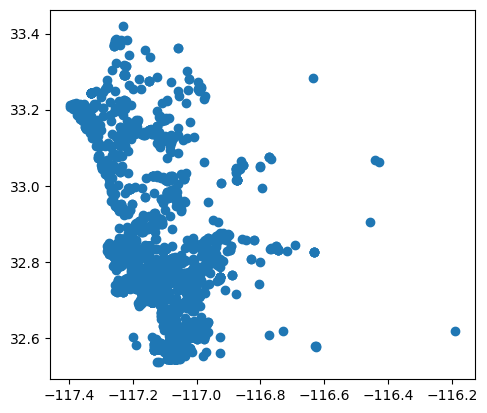

In [87]:
not_empty2.plot()

In [88]:
df_empty= not_empty[(not_empty['x_coordinate']==0) | (not_empty['y_coordinate']==0)]
df_empty.count

<bound method DataFrame.count of       x_coordinate nature_of_complaint record_status      record_number  \
983            0.0           Open Burn        Closed  APCD2024-CMP-0046   
995            0.0                Dust        Closed  APCD2023-CMP-0581   
1227           0.0               Smoke        Closed  APCD2024-CMP-0074   
1306           0.0                Odor        Closed  APCD2024-CMP-0154   
1308           0.0                Odor        Closed  APCD2024-CMP-0156   
1339           0.0              Idling        Closed  APCD2024-CMP-0189   
3192           0.0                Odor        Closed  APCD2024-CMP-2249   
4239           0.0                Odor        Closed  APCD2024-CMP-3421   
4307           0.0                Odor        Closed  APCD2024-CMP-3507   

            investigation_outcome  date_received  response_duration__hours_  \
983   No Enforcement Action Taken   1.706342e+12                   0.700000   
995   No Enforcement Action Taken   1.698390e+12          

In [89]:
not_empty2.groupby('date')['hour'].count()

date
2022-04-01     3
2022-04-03     1
2022-04-04     1
2022-04-05     1
2022-04-06     3
              ..
2025-03-28     2
2025-03-29     2
2025-03-30     3
2025-03-31    22
2025-04-01     1
Name: hour, Length: 869, dtype: int64

In [90]:
not_empty2.groupby('x_coordinate').count().sort_values(by='x_coordinate')

,nature_of_complaint,record_status,record_number,investigation_outcome,date_received,response_duration__hours_,y_coordinate,geometry,datetime,date,hour,Icon
x_coordinate,,,,,,,,,,,,
-117.397528,1,1,1,1,1,1,1,1,1,1,1,1
-117.395606,1,1,1,1,1,1,1,1,1,1,1,1
-117.388007,1,1,1,1,1,1,1,1,1,1,1,1
-117.387428,1,1,1,0,1,0,1,1,1,1,1,1
-117.387422,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
-116.625319,1,1,1,1,1,1,1,1,1,1,1,1
-116.457258,1,1,1,1,1,1,1,1,1,1,1,1
-116.439476,1,1,1,1,1,1,1,1,1,1,1,1


In [91]:
not_empty2.groupby('y_coordinate').count().sort_values(by='y_coordinate')

,x_coordinate,nature_of_complaint,record_status,record_number,investigation_outcome,date_received,response_duration__hours_,geometry,datetime,date,hour,Icon
y_coordinate,,,,,,,,,,,,
32.535167,1,1,1,1,1,1,1,1,1,1,1,1
32.536421,1,1,1,1,1,1,1,1,1,1,1,1
32.543245,1,1,1,1,0,1,0,1,1,1,1,1
32.543711,1,1,1,1,0,1,0,1,1,1,1,1
32.543764,1,1,1,1,0,1,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
33.381959,1,1,1,1,1,1,1,1,1,1,1,1
33.382105,1,1,1,1,1,1,1,1,1,1,1,1
33.383937,1,1,1,1,1,1,1,1,1,1,1,1


In [92]:
default_loc_df= not_empty2[(not_empty2['x_coordinate']<-117.078) & (not_empty2['x_coordinate']>-117.082)]
default_loc_df.count

<bound method DataFrame.count of       x_coordinate nature_of_complaint record_status      record_number  \
2      -117.078051                Dust        Closed  APCD2022-CMP-0184   
4      -117.078051          Dust, Odor        Closed  APCD2022-CMP-0186   
5      -117.078051                Odor        Closed  APCD2022-CMP-0187   
6      -117.078051                Odor        Closed  APCD2022-CMP-0188   
7      -117.078051                Odor        Closed  APCD2022-CMP-0189   
...            ...                 ...           ...                ...   
5248   -117.081305                Odor          Open  APCD2025-CMP-0530   
5253   -117.081305                Odor          Open  APCD2025-CMP-0536   
5254   -117.081305                Odor          Open  APCD2025-CMP-0537   
5255   -117.081305                Odor          Open  APCD2025-CMP-0538   
5256   -117.081305                Odor          Open  APCD2025-CMP-0539   

            investigation_outcome  date_received  response_duratio

In [93]:
default_loc_df.groupby(['x_coordinate', 'y_coordinate'])['datetime']

In [94]:
issue_df=not_empty2[(not_empty2['x_coordinate']==-117.081305) & (not_empty2['y_coordinate']==32.552044)]

issue_df[['x_coordinate', 'y_coordinate', 'datetime']].describe()

,x_coordinate,y_coordinate,datetime
count,2730.000000,2.730000e+03,2729
mean,-117.081305,3.255204e+01,2024-09-30 12:00:44.851593984
min,-117.081305,3.255204e+01,2023-08-05 07:00:00
25%,-117.081305,3.255204e+01,2024-08-19 07:00:00
50%,-117.081305,3.255204e+01,2024-09-09 07:00:00
75%,-117.081305,3.255204e+01,2024-10-22 07:00:00
max,-117.081305,3.255204e+01,2025-04-01 07:00:00
std,0.000000,7.106729e-15,NaN


In [95]:
from foursquare.data_sdk import DataSDK, MediaType
import os
refresh_token=os.getenv("RC_FSQ_REFRESH_TOKEN")
client = DataSDK()

In [96]:
client.upload_dataframe(
            not_empty2,
           dataset="832a74c0-5ce1-4188-9be9-45f22809cd3b",
            name='SD Complaints',
            description="SD Complaints from dataframe")
import datetime
last_30_gdf= not_empty2[not_empty2["datetime"]>=datetime.datetime(2025,1,1)]
client.upload_dataframe(
            last_30_gdf,
           dataset="1ab2b010-f761-4b36-9063-576f3f3964a3",
            name='SD Complaints 30 days',
            description="SD Complaints from dataframe")

Compressing file
Uploading: 100%|██████████| 97.9k/97.9k [00:00<00:00, 158kB/s]
Compressing file
Uploading: 100%|██████████| 8.01k/8.01k [00:00<00:00, 17.5kB/s]


Dataset(id=UUID('1ab2b010-f761-4b36-9063-576f3f3964a3'), name='SD Complaints 30 days', type=<DatasetType.MANAGED: 'managed'>, created_at=datetime.datetime(2025, 2, 13, 18, 10, 53, tzinfo=TzInfo(UTC)), updated_at=datetime.datetime(2025, 4, 3, 22, 20, 21, tzinfo=TzInfo(UTC)), description='SD Complaints from dataframe', is_valid=True, data_connector=None, metadata=DatasetMetadata(media_type='text/csv', size=77928, source=None, tileset_data_url=None, tileset_metadata_url=None, image_url=None, metadata_url=None, data_status=None))

Tract


In [22]:
df

,x_coordinate,nature_of_complaint,record_status,record_number,investigation_outcome,date_received,response_duration__hours_,y_coordinate,geometry,datetime,date,hour,Icon
0,-116.925050,Odor,Closed,APCD2022-CMP-0182,Unable to Validate,1.648796e+12,0.883333,32.559283,POINT (-116.92505 32.55928),2022-04-01 07:00:00,2022-04-01,7.0,pin
1,-117.169871,"Odor, Smoke",Closed,APCD2022-CMP-0183,No Enforcement Action Taken,1.648796e+12,0.533333,32.738743,POINT (-117.16987 32.73874),2022-04-01 07:00:00,2022-04-01,7.0,pin
2,-117.078051,Dust,Closed,APCD2022-CMP-0184,No Enforcement Action Taken,1.648969e+12,19.133333,32.808579,POINT (-117.07805 32.80858),2022-04-03 07:00:00,2022-04-03,7.0,pin
3,-117.280043,Dust,Closed,APCD2022-CMP-0185,Referred,1.648796e+12,64.516667,33.067866,POINT (-117.28004 33.06787),2022-04-01 07:00:00,2022-04-01,7.0,pin
4,-117.078051,"Dust, Odor",Closed,APCD2022-CMP-0186,No Enforcement Action Taken,1.649056e+12,0.666667,32.808579,POINT (-117.07805 32.80858),2022-04-04 07:00:00,2022-04-04,7.0,pin
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5252,-117.320294,None,Open,APCD2025-CMP-0535,None,1.743404e+12,NaN,33.143556,POINT (-117.32029 33.14356),2025-03-31 07:00:00,2025-03-31,7.0,pin
5253,-117.081305,Odor,Open,APCD2025-CMP-0536,None,1.743404e+12,NaN,32.552044,POINT (-117.0813 32.55204),2025-03-31 07:00:00,2025-03-31,7.0,pin
5254,-117.081305,Odor,Open,APCD2025-CMP-0537,None,1.743404e+12,NaN,32.552044,POINT (-117.0813 32.55204),2025-03-31 07:00:00,2025-03-31,7.0,pin
5255,-117.081305,Odor,Open,APCD2025-CMP-0538,None,1.743404e+12,NaN,32.552044,POINT (-117.0813 32.55204),2025-03-31 07:00:00,2025-03-31,7.0,pin


In [40]:
tract_gdf=gpd.read_file("https://oss.resilientservice.mooo.com/resilentpublic/tijuana/geographic/tracts_cleanwater.geojson")
#tract_gdf.normalize()

In [45]:
tract_clean_gdf= tract_gdf[['tract','geometry']].drop_duplicates(['tract','geometry'])
tract_clean_gdf

,tract,geometry
0,Census Tract 100,"POLYGON ((-117.18538 32.75873, -117.18528 32.7..."
2,Census Tract 13410,"POLYGON ((-116.98571 32.66468, -116.98648 32.6..."
5,Census Tract 1000,"POLYGON ((-117.14353 32.76317, -117.14353 32.7..."
9,Census Tract 10001,"POLYGON ((-117.04563 32.58771, -117.04545 32.5..."
10,Census Tract 10003,"POLYGON ((-117.03823 32.58372, -117.03804 32.5..."
...,...,...
1861,Census Tract 9802,"POLYGON ((-117.00653 32.79132, -117.00714 32.7..."
1863,Census Tract 9804,"POLYGON ((-117.00602 32.813, -117.00595 32.812..."
1866,Census Tract 9801,"POLYGON ((-117.0374 32.79148, -117.03739 32.79..."
1872,Census Tract 9805,"POLYGON ((-117.04818 32.80597, -117.04828 32.8..."


In [61]:
joined_gdf = gpd.sjoin(default_loc_df,tract_clean_gdf,  how='inner', predicate='intersects', rsuffix='_tract')
joined_gdf 

,x_coordinate,nature_of_complaint,record_status,record_number,investigation_outcome,date_received,response_duration__hours_,y_coordinate,geometry,datetime,date,hour,Icon,index__tract,tract
2,-117.078051,Dust,Closed,APCD2022-CMP-0184,No Enforcement Action Taken,1.648969e+12,19.133333,32.808579,POINT (-117.07805 32.80858),2022-04-03 07:00:00,2022-04-03,7.0,pin,1832,Census Tract 9507
4,-117.078051,"Dust, Odor",Closed,APCD2022-CMP-0186,No Enforcement Action Taken,1.649056e+12,0.666667,32.808579,POINT (-117.07805 32.80858),2022-04-04 07:00:00,2022-04-04,7.0,pin,1832,Census Tract 9507
5,-117.078051,Odor,Closed,APCD2022-CMP-0187,No Enforcement Action Taken,1.649142e+12,6.500000,32.808579,POINT (-117.07805 32.80858),2022-04-05 07:00:00,2022-04-05,7.0,pin,1832,Census Tract 9507
6,-117.078051,Odor,Closed,APCD2022-CMP-0188,No Enforcement Action Taken,1.649228e+12,0.900000,32.808579,POINT (-117.07805 32.80858),2022-04-06 07:00:00,2022-04-06,7.0,pin,1832,Census Tract 9507
7,-117.078051,Odor,Closed,APCD2022-CMP-0189,No Enforcement Action Taken,1.649228e+12,0.300000,32.808579,POINT (-117.07805 32.80858),2022-04-06 07:00:00,2022-04-06,7.0,pin,1832,Census Tract 9507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5248,-117.081305,Odor,Open,APCD2025-CMP-0530,None,1.743404e+12,NaN,32.552044,POINT (-117.0813 32.55204),2025-03-31 07:00:00,2025-03-31,7.0,pin,57,Census Tract 10109
5253,-117.081305,Odor,Open,APCD2025-CMP-0536,None,1.743404e+12,NaN,32.552044,POINT (-117.0813 32.55204),2025-03-31 07:00:00,2025-03-31,7.0,pin,57,Census Tract 10109
5254,-117.081305,Odor,Open,APCD2025-CMP-0537,None,1.743404e+12,NaN,32.552044,POINT (-117.0813 32.55204),2025-03-31 07:00:00,2025-03-31,7.0,pin,57,Census Tract 10109
5255,-117.081305,Odor,Open,APCD2025-CMP-0538,None,1.743404e+12,NaN,32.552044,POINT (-117.0813 32.55204),2025-03-31 07:00:00,2025-03-31,7.0,pin,57,Census Tract 10109


In [67]:
joined2_gdf = gpd.sjoin(
    tract_clean_gdf,
    default_loc_df,
    how='left',
    predicate='contains'
)
joined2_gdf.dropna(how='any', subset=['x_coordinate', 'y_coordinate'])

,tract,geometry,index_right,x_coordinate,nature_of_complaint,record_status,record_number,investigation_outcome,date_received,response_duration__hours_,y_coordinate,datetime,date,hour,Icon
47,Census Tract 10106,"POLYGON ((-117.08228 32.57648, -117.08223 32.5...",2055.0,-117.078994,Odor,Closed,APCD2024-CMP-0951,None,1.723100e+12,NaN,32.575515,2024-08-08 07:00:00,2024-08-08,7.0,pin
57,Census Tract 10109,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",1002.0,-117.078361,Odor,Closed,APCD2023-CMP-0589,Outside APCD Jurisdiction,1.698649e+12,1.000000,32.550748,2023-10-30 07:00:00,2023-10-30,7.0,pin
57,Census Tract 10109,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",1593.0,-117.079763,Odor,Closed,APCD2024-CMP-0462,Enforcement Action Taken,1.721545e+12,0.066667,32.550887,2024-07-21 07:00:00,2024-07-21,7.0,pin
57,Census Tract 10109,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",4822.0,-117.081305,Odor,Open,APCD2025-CMP-0044,None,1.736064e+12,NaN,32.552044,2025-01-05 08:00:00,2025-01-05,8.0,pin
57,Census Tract 10109,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",4823.0,-117.081305,Odor,Open,APCD2025-CMP-0045,None,1.736064e+12,NaN,32.552044,2025-01-05 08:00:00,2025-01-05,8.0,pin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,Census Tract 9507,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",4673.0,-117.078051,Odor,Closed,APCD2024-CMP-3907,No Enforcement Action Taken,1.733904e+12,5.050000,32.808579,2024-12-11 08:00:00,2024-12-11,8.0,pin
1832,Census Tract 9507,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",4676.0,-117.078051,Odor,Closed,APCD2024-CMP-3910,No Enforcement Action Taken,1.733904e+12,5.233333,32.808579,2024-12-11 08:00:00,2024-12-11,8.0,pin
1832,Census Tract 9507,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",1267.0,-117.078051,Odor,Closed,APCD2024-CMP-0114,No Enforcement Action Taken,1.709021e+12,0.300000,32.808579,2024-02-27 08:00:00,2024-02-27,8.0,pin
1832,Census Tract 9507,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",1266.0,-117.078051,Odor,Closed,APCD2024-CMP-0113,No Enforcement Action Taken,1.709021e+12,1.083333,32.808579,2024-02-27 08:00:00,2024-02-27,8.0,pin


In [68]:
complaint_groupby_tract = joined2_gdf[joined2_gdf['nature_of_complaint'] == 'Odor'].groupby(
    by=['tract','date', 'nature_of_complaint', 'geometry'],  as_index=False).agg(count=('date_received', 'count'))
complaint_groupby_tract['Icon'] = 'pin'
complaint_groupby_tract

,tract,date,nature_of_complaint,geometry,count,Icon
0,Census Tract 10106,2024-08-08,Odor,"POLYGON ((-117.08228 32.57648, -117.08223 32.5...",1,pin
1,Census Tract 10109,2023-08-05,Odor,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",1,pin
2,Census Tract 10109,2023-09-08,Odor,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",1,pin
3,Census Tract 10109,2023-09-09,Odor,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",2,pin
4,Census Tract 10109,2023-10-30,Odor,"POLYGON ((-117.11883 32.54823, -117.11881 32.5...",1,pin
...,...,...,...,...,...,...
364,Census Tract 9507,2025-02-21,Odor,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",1,pin
365,Census Tract 9507,2025-02-25,Odor,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",1,pin
366,Census Tract 9507,2025-03-04,Odor,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",1,pin
367,Census Tract 9507,2025-03-21,Odor,"POLYGON ((-117.08065 32.80924, -117.08083 32.8...",1,pin


In [72]:
df_geojson= complaint_groupby_tract.to_json(na='drop')

TypeError: to_json() got an unexpected keyword argument 'na'

In [73]:
complaint_groupby_tract.colums

,count
count,369.000000
mean,7.880759
std,18.376701
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,226.000000


In [74]:
complaint_groupby_tract2=gpd.GeoDataFrame(complaint_groupby_tract)

In [75]:
df_geojson= complaint_groupby_tract2.to_json(na='drop')

In [76]:
complaint_groupby_tract2.drop('geometry', axis='columns')

,tract,date,nature_of_complaint,count,Icon
0,Census Tract 10106,2024-08-08,Odor,1,pin
1,Census Tract 10109,2023-08-05,Odor,1,pin
2,Census Tract 10109,2023-09-08,Odor,1,pin
3,Census Tract 10109,2023-09-09,Odor,2,pin
4,Census Tract 10109,2023-10-30,Odor,1,pin
...,...,...,...,...,...
364,Census Tract 9507,2025-02-21,Odor,1,pin
365,Census Tract 9507,2025-02-25,Odor,1,pin
366,Census Tract 9507,2025-03-04,Odor,1,pin
367,Census Tract 9507,2025-03-21,Odor,1,pin


In [78]:
joined2_gdf = gpd.sjoin(
    tract_clean_gdf,
    default_loc_df,
    how='left',
    predicate='contains'
)
joined2_gdf=joined2_gdf.dropna(how='any', subset=['x_coordinate', 'y_coordinate']).drop_duplicates(['tract','geometry'])
joined2_gdf.set_index(['tract','date', 'nature_of_complaint'],inplace=True)


In [79]:
joined2_gdf.drop('geometry', axis='columns')

,,,index_right,x_coordinate,record_status,record_number,investigation_outcome,date_received,response_duration__hours_,y_coordinate,datetime,hour,Icon
tract,date,nature_of_complaint,,,,,,,,,,,
Census Tract 10106,2024-08-08,Odor,2055.0,-117.078994,Closed,APCD2024-CMP-0951,None,1.723100e+12,NaN,32.575515,2024-08-08 07:00:00,7.0,pin
Census Tract 10109,2023-10-30,Odor,1002.0,-117.078361,Closed,APCD2023-CMP-0589,Outside APCD Jurisdiction,1.698649e+12,1.000000,32.550748,2023-10-30 07:00:00,7.0,pin
Census Tract 10112,2023-09-08,Odor,879.0,-117.080649,Closed,APCD2023-CMP-0459,No Enforcement Action Taken,1.694156e+12,9.016667,32.573168,2023-09-08 07:00:00,7.0,pin
Census Tract 12303,2024-07-24,Dust,1749.0,-117.078079,Closed,APCD2024-CMP-0621,No Enforcement Action Taken,1.721804e+12,0.350000,32.649189,2024-07-24 07:00:00,7.0,pin
Census Tract 12304,2024-03-08,Smoke,1301.0,-117.078781,Closed,APCD2024-CMP-0149,No Enforcement Action Taken,1.709885e+12,13.800000,32.644395,2024-03-08 08:00:00,8.0,pin
Census Tract 12700,2024-08-11,Odor,2479.0,-117.081398,Open,APCD2024-CMP-1418,None,1.723360e+12,NaN,32.637320,2024-08-11 07:00:00,7.0,pin
Census Tract 13104,2022-09-28,"Dust, Odor",297.0,-117.081413,Closed,APCD2022-CMP-0632,No Enforcement Action Taken,1.664348e+12,15.416667,32.614084,2022-09-28 07:00:00,7.0,pin
Census Tract 2708,2023-09-18,Smoke,907.0,-117.081802,Closed,APCD2023-CMP-0491,No Enforcement Action Taken,1.695020e+12,0.950000,32.755054,2023-09-18 07:00:00,7.0,pin
Census Tract 17031,2025-03-26,"Asbestos, Dust",5218.0,-117.081830,Open,APCD2025-CMP-0499,None,1.742972e+12,NaN,33.025077,2025-03-26 07:00:00,7.0,pin


Checking for last updated

In [15]:
base_url= 'https://gis-public.sandiegocounty.gov/arcgis/rest/services/Hosted/SDAPCD_Complaints/FeatureServer/0/'
meta_url= f'{base_url}metadata'

response = requests.get(meta_url)
if response.status_code == 200:
    xml = response.text
    root = ET.fromstring(xml)
    print(root.tag) 
    create_date = root.find('./Esri/CreaDate').text
    print(create_date)
    

metadata
20250415
